Таблица основных гиперпараметров RandomForestRegressor:
       Гиперпараметр                                   Описание
0       n_estimators                 Количество деревьев в лесу
1          max_depth                Максимальная глубина дерева
2  min_samples_split        Минимум объектов для разбиения узла
3   min_samples_leaf                   Минимум объектов в листе
4       max_features  Число признаков для поиска лучшего сплита

GRID SEARCH
Лучшие параметры GridSearch:
{'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 300}
MSE GridSearch: 1.5077210873228846e+16

RANDOM SEARCH


[I 2025-11-29 11:40:33,073] A new study created in memory with name: no-name-03972c20-2b95-4604-a122-48a997990a17


Лучшие параметры RandomSearch:
{'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__max_depth': None}
MSE RandomSearch: 1.5478169879160896e+16

OPTUNA SEARCH


[I 2025-11-29 11:40:35,596] Trial 0 finished with value: 1.533087668944909e+16 and parameters: {'n_estimators': 136, 'max_depth': 26, 'min_samples_split': 8}. Best is trial 0 with value: 1.533087668944909e+16.
[I 2025-11-29 11:40:36,913] Trial 1 finished with value: 1.514549263829686e+16 and parameters: {'n_estimators': 85, 'max_depth': 10, 'min_samples_split': 9}. Best is trial 1 with value: 1.514549263829686e+16.
[I 2025-11-29 11:40:39,198] Trial 2 finished with value: 1.4967599647424654e+16 and parameters: {'n_estimators': 117, 'max_depth': 22, 'min_samples_split': 5}. Best is trial 2 with value: 1.4967599647424654e+16.
[I 2025-11-29 11:40:44,116] Trial 3 finished with value: 1.5143238406761092e+16 and parameters: {'n_estimators': 280, 'max_depth': 13, 'min_samples_split': 5}. Best is trial 2 with value: 1.4967599647424654e+16.
[I 2025-11-29 11:40:46,297] Trial 4 finished with value: 1.5044370209859606e+16 and parameters: {'n_estimators': 97, 'max_depth': 28, 'min_samples_split': 2}

Лучшие параметры Optuna:
{'n_estimators': 131, 'max_depth': 12, 'min_samples_split': 5}
MSE Optuna: 1.4863087578715278e+16

Сравнение методов подбора гиперпараметров:
          Метод                                   Лучшие параметры  \
0    GridSearch  {'model__max_depth': 10, 'model__min_samples_s...   
1  RandomSearch  {'model__n_estimators': 400, 'model__min_sampl...   
2        Optuna  {'n_estimators': 131, 'max_depth': 12, 'min_sa...   

            MSE  
0  1.507721e+16  
1  1.547817e+16  
2  1.486309e+16  

Лучший метод подбора гиперпараметров:
Метод: Optuna
Лучшие параметры: {'n_estimators': 131, 'max_depth': 12, 'min_samples_split': 5}
Лучшее MSE: 1.4863087578715278e+16

Глобальная интерпретация SHAP:


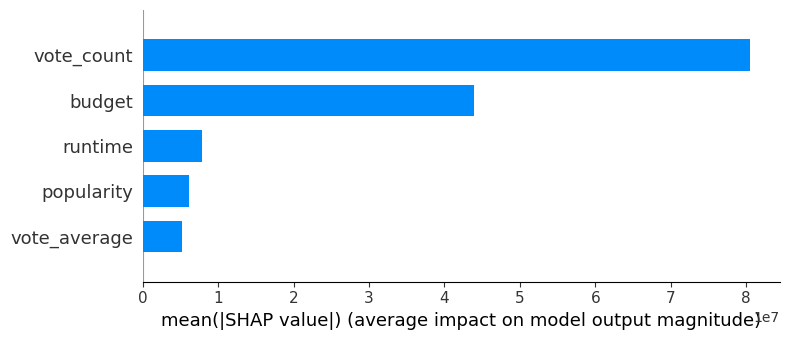

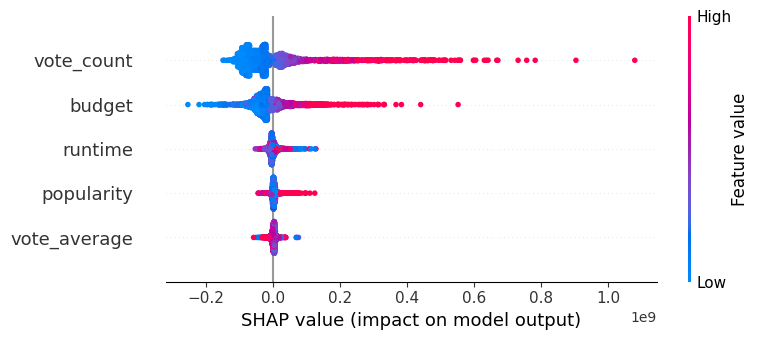


Пример локальной интерпретации LIME для объекта с индексом 0:


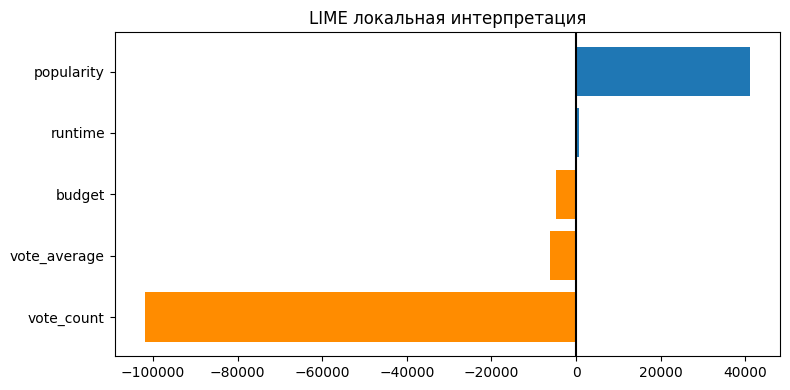


Пример локальной интерпретации LIME для кастомного фильма:

Прогноз выручки фильма:
192,699,800 $


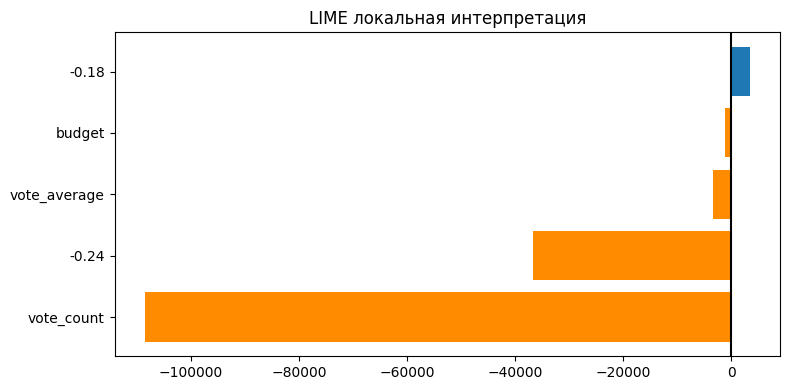

(np.float64(192699800.03652117),
 <lime.explanation.Explanation at 0x1a6607285c0>)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import optuna
import shap
import lime.lime_tabular as lime_tabular
import warnings
warnings.filterwarnings("ignore")

movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv").rename(columns={"movie_id": "id"})
df = movies.merge(credits, on="id")
df_clean = df[["budget", "popularity", "vote_average", "vote_count", "runtime", "revenue"]].replace(0, np.nan).dropna()

X = df_clean.drop("revenue", axis=1)
y = df_clean["revenue"]
num_features = X.columns.tolist()

params_table = pd.DataFrame([
    ["n_estimators", "Количество деревьев в лесу"],
    ["max_depth", "Максимальная глубина дерева"],
    ["min_samples_split", "Минимум объектов для разбиения узла"],
    ["min_samples_leaf", "Минимум объектов в листе"],
    ["max_features", "Число признаков для поиска лучшего сплита"]
], columns=["Гиперпараметр", "Описание"])

print("Таблица основных гиперпараметров RandomForestRegressor:")
print(params_table)

preprocess = ColumnTransformer([("num", StandardScaler(), num_features)])
base_model = RandomForestRegressor(random_state=42)
pipe = Pipeline([("prep", preprocess), ("model", base_model)])

grid_params = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

rand_params = {
    "model__n_estimators": [50, 100, 200, 400],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10]
}

def evaluate_model(pipe_obj, X_data, y_data):
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    pipe_obj.fit(X_train, y_train)
    preds = pipe_obj.predict(X_val)
    return mean_squared_error(y_val, preds)

print("\nGRID SEARCH")
grid = GridSearchCV(pipe, grid_params, cv=3, n_jobs=-1)
grid.fit(X, y)
grid_best_params = grid.best_params_
grid_mse = evaluate_model(grid.best_estimator_, X, y)
print("Лучшие параметры GridSearch:")
print(grid_best_params)
print("MSE GridSearch:", grid_mse)

print("\nRANDOM SEARCH")
random_search = RandomizedSearchCV(pipe, rand_params, cv=3, n_iter=10, n_jobs=-1)
random_search.fit(X, y)
random_best_params = random_search.best_params_
random_mse = evaluate_model(random_search.best_estimator_, X, y)
print("Лучшие параметры RandomSearch:")
print(random_best_params)
print("MSE RandomSearch:", random_mse)

print("\nOPTUNA SEARCH")
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
    }
    model = RandomForestRegressor(
        random_state=42,
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"]
    )
    pipe_opt = Pipeline([("prep", preprocess), ("model", model)])
    return evaluate_model(pipe_opt, X, y)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
optuna_best_params = study.best_params
optuna_mse = study.best_value
print("Лучшие параметры Optuna:")
print(optuna_best_params)
print("MSE Optuna:", optuna_mse)

results = pd.DataFrame([
    ["GridSearch", grid_best_params, grid_mse],
    ["RandomSearch", random_best_params, random_mse],
    ["Optuna", optuna_best_params, optuna_mse]
], columns=["Метод", "Лучшие параметры", "MSE"])

print("\nСравнение методов подбора гиперпараметров:")
print(results)

best_row = results.loc[results["MSE"].idxmin()]
best_method_name = best_row["Метод"]
print("\nЛучший метод подбора гиперпараметров:")
print("Метод:", best_method_name)
print("Лучшие параметры:", best_row["Лучшие параметры"])
print("Лучшее MSE:", best_row["MSE"])

if best_method_name == "GridSearch":
    best_pipe = grid.best_estimator_
elif best_method_name == "RandomSearch":
    best_pipe = random_search.best_estimator_
else:
    best_model = RandomForestRegressor(
        random_state=42,
        n_estimators=optuna_best_params["n_estimators"],
        max_depth=optuna_best_params["max_depth"],
        min_samples_split=optuna_best_params["min_samples_split"]
    )
    best_pipe = Pipeline([("prep", preprocess), ("model", best_model)])

best_pipe.fit(X, y)

explainer = shap.TreeExplainer(best_pipe.named_steps["model"])
X_transformed = best_pipe.named_steps["prep"].transform(X)
shap_values = explainer.shap_values(X_transformed)

print("\nГлобальная интерпретация SHAP:")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=num_features,
    mode="regression"
)

def pipe_predict_from_lime(x):
    df_temp = pd.DataFrame(x, columns=num_features)
    return best_pipe.predict(df_temp)

def plot_lime_explanation(exp):
    exp_list = exp.as_list()
    lime_df = pd.DataFrame(exp_list, columns=["Feature", "Contribution"])
    lime_df["Feature"] = lime_df["Feature"].apply(lambda s: s.split(" ")[0])
    lime_df = lime_df.sort_values("Contribution", ascending=True)
    colors = lime_df["Contribution"].apply(lambda v: "#ff8c00" if v < 0 else "#1f77b4")
    plt.figure(figsize=(8, 4))
    plt.barh(lime_df["Feature"], lime_df["Contribution"], color=colors)
    plt.axvline(0, color="black")
    plt.title("LIME локальная интерпретация")
    plt.tight_layout()
    plt.show()

print("\nПример локальной интерпретации LIME для объекта с индексом 0:")
exp_sample = lime_explainer.explain_instance(X_transformed[0], pipe_predict_from_lime)
plot_lime_explanation(exp_sample)

def movie_predict(budget, popularity, vote_avg, vote_cnt, runtime):
    x = pd.DataFrame([{
        "budget": budget,
        "popularity": popularity,
        "vote_average": vote_avg,
        "vote_count": vote_cnt,
        "runtime": runtime
    }])
    pred = best_pipe.predict(x)[0]
    x_t = best_pipe.named_steps["prep"].transform(x)
    exp = lime_explainer.explain_instance(x_t[0], pipe_predict_from_lime)
    print("\nПрогноз выручки фильма:")
    print(f"{pred:,.0f} $")
    plot_lime_explanation(exp)
    return pred, exp

print("\nПример локальной интерпретации LIME для кастомного фильма:")
movie_predict(100_000_000, 30, 7.2, 2000, 120)
